# Fourier Analysis

Any time-series can be equally well-represented in the frequency-domain. In this notebook we will look at what seismic data look like in the frequency-domain, and think about the effect of different recording instrumentation on seismic data.

The main topics that we will cover are:
1. Fourier transforms of seismic data;
2. Comparison of teleseismic signals and local signals in the frequency-domain;
3. The effect of filters in the frequency domain.

# 1.0 Fourier Transforms

Fourier transforms convert from periodic functions (in our case, periodic in time or space, defined as $a(t)$ below) to a Fourier series of orthogonal sine and cosine functions:

\begin{equation*}
    a(t) = \frac{1}{2}a_0 + \sum_{n=1}^{\infty}(c_n cos(n{\omega}t) + s_n sin(n{\omega}t))
\end{equation*}

When $s_n$ and $c_n$ are Fourier coefficients, $t$ is time, $a$ is amplitude and $\omega$ is angular frequency.

In seismology we use the Fourier transform to convert from the time domain to the frequency domain. Because we are dealing with digital data (discretely sampled) we make use of the discrete Fourier transform (DFT). We will often refer to the Fast Fourier transform (FFT) as well, which is an efficient computational
implementation of the DFT. The Fourier transform allows us to study the frequencies that make up our seismogram - you will use this in future when computing moment magnitudes and thinking about earthquake source processes.  Over longer time-series we can also look at the the frequencies of various normal modes of the earth.

One of the most common uses for the Fourier transform in seismology is when filtering seismograms.  Filters work as convolutions in the time domain, or multiplications in the frequency domain.  Because multiplication is more computationally efficient than convolution, filtering is commonly (*but not exclusively! - ObsPy filters in the time domain*) done in the frequency domain.  Of key importance here is that we can convert back from the frequency domain to the time domain using the inverse Fourier transform (IFT).

In this notebook we will look at the Fourier spectrums of a few different signals - we will also play with decimating our data and see what effect this has on the frequency content.

Note: Discrete Fourier transforms assume that the data can be **represented by periodic functions**, thus the data that you are transforming is assumed to be periodic and should start and end at the same value to allow wraparound.  One way that we cope with this in seismology is to detrend our data (so that the start and end are zero).

**You should always detrend your data before doing any time-frequency conversion.** It can also be helpful to [taper](https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.taper.html) your data to suppress large amplitudes close to the end of traces.

In [1]:
# Set up notebook
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
plt.style.use('ggplot')

We will use a function in the "tools" module (open the `gphs445_utilities/tools.py` file to have a look at the contents)
to make some plots of the Fourier transform of out data.

In [2]:
from gphs445_utilities.tools import plot_fft

plot_fft?

<IPython.core.display.Javascript object>


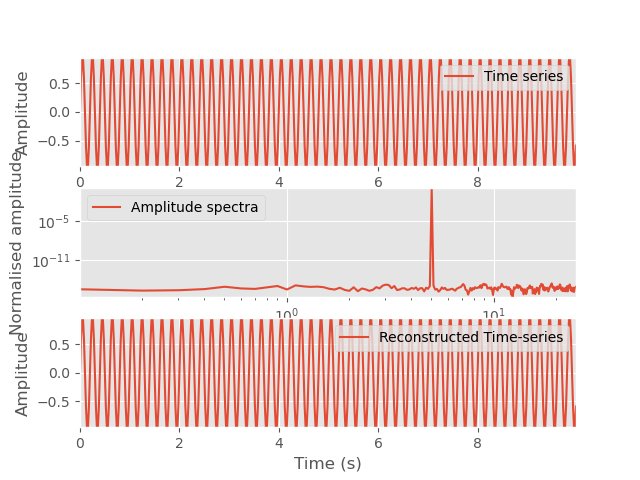

In [3]:
sample_frequency = 50
dt = 1 / sample_frequency
sine_freq = 5
x = np.arange(0.0, 50 * (1 / sine_freq), dt)
y = np.sin(x * sine_freq * 2 * np.pi)

fig = plot_fft(x, y)
fig.show()

With this simple sine curve we get a nice clear peak in the frequency spectra at the frequency of the input sine curve.

Lets try adding in a second, higher frequency since curve and see what that looks like.

**Exercise**: In the code below, try adding another different sine wave of a similar frequency and see if you can resolve it in the frequency domain.  Change the `second_sine_freq` variable and re-run a few times to get a feel for this.

After you have played around with adding sine waves, try multiplying - you should see an effect similar to the constructive and destructive interference we discussed when talking about surface waves.

<IPython.core.display.Javascript object>


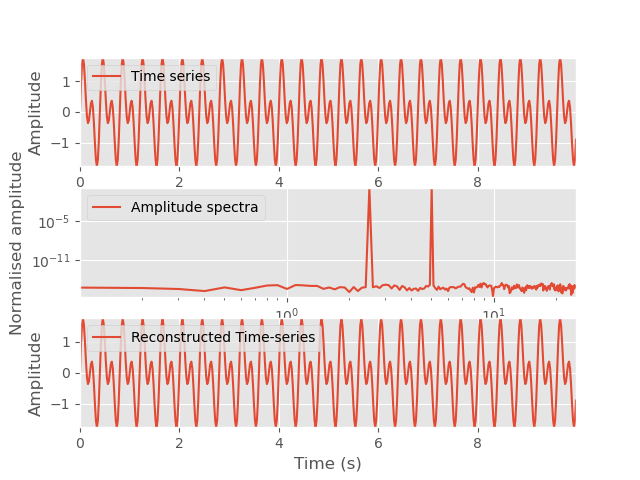

In [4]:
second_sine_freq = 2.5

y_2 = y + np.sin(x * second_sine_freq * 2 * np.pi)

fig = plot_fft(x, y_2)
fig.show()

Now lets try some real data.

A call to ObsPy's `read()` function without an argument will load their example data.

<IPython.core.display.Javascript object>


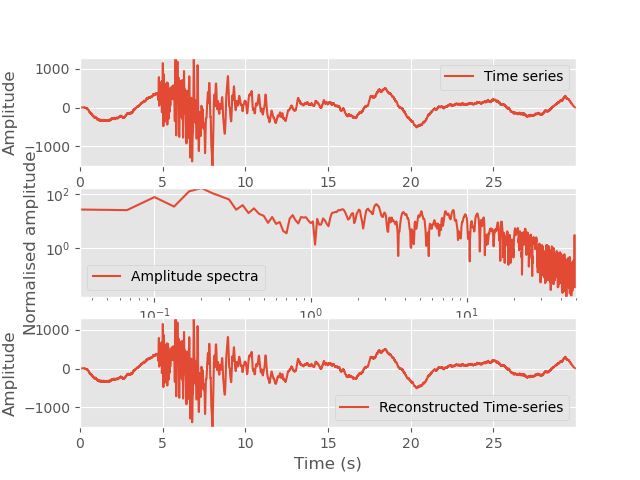

In [5]:
tr = read()[0]
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data

fig = plot_fft(x, y)
fig.show()

**Question:** What is the dominant frequency here?

You can see it in the raw data - this background low-frequency energy is often related to the 
Earth's noise microseisms. Also note that the amplitude of the frequency spectra falls off with
increasing frequency. We will use this later to estimate moment magnitude.

Lets see what our spectra looks like when we decimate our seismic data. Decimation is when we regularly remove samples to reduce the sampling-rate. For example, decimating 100 Hz data by a factor of two will retain every second sample resulting in a sampling-rate of 50 Hz, decimating by a factor of 10 would retain only every tenth sample resulting in a sampling-rate of 10 Hz.

<IPython.core.display.Javascript object>


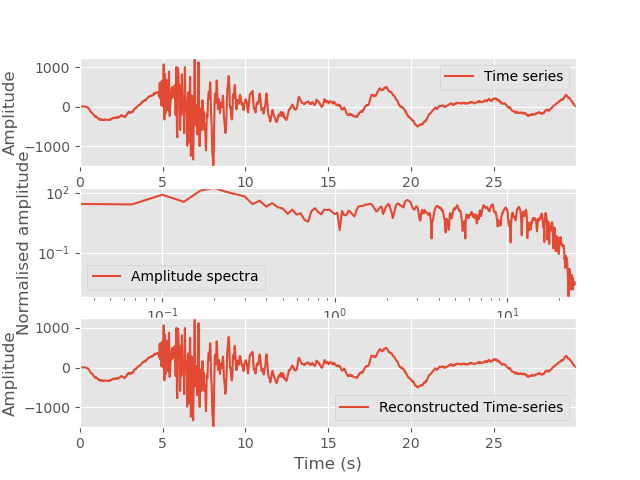

In [6]:
tr_decimated = tr.copy().decimate(2)  
# Decimation work "in-place" on the data, so we work on a copy to retain the original data

x = np.arange(0, tr_decimated.stats.npts * tr_decimated.stats.delta, tr_decimated.stats.delta)
y = tr_decimated.data

fig = plot_fft(x, y)
fig.show()

**Exercise:** Play around with other decimation factors.  What do you see happening to the spectra of the decimated seismogram?

---

## 1.1: Gibb's phenomenon

Because we are using a DFT (Discrete Fourier Transform), which uses only a finite number of terms to
describe the frequency content, we are susceptible to Gibb's phenomenon. Gibb's phenomemon occurs where
there are discontinuities in the time-series (or equally, when there are discontinuities in the
spectrum).  A disconinuity (e.g. something like a step) cannot to represented accurately with a 
finite number of sine waves: a step in the time-domain contains infinite frequencies.  The oscillations
associated with the overshoot of sine-waves is known as Gibb's phenomenon.

In the below example we artificially introduce a step into the previous time-series. Note that
this step offset also introduces a step at the start and end of the time-series because the
Fourier transform assumes the signal is periodic.  We see that our frequency spectra "rings",
constantly returning to an almost flat spectrum up to the Nyquist.

<IPython.core.display.Javascript object>


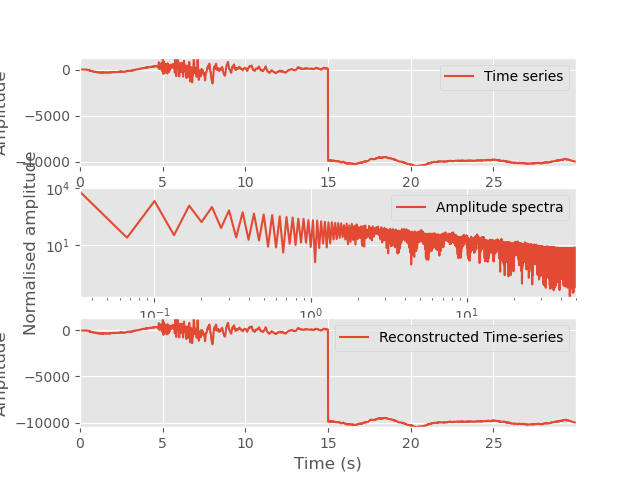

In [7]:
step_position = int(tr.stats.npts / 2)
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
tr_stepped = tr.copy()
tr_stepped.data[step_position:] -= 1e4
y = tr_stepped.data

fig = plot_fft(x, y)
fig.show()

Similarly, if we generate a frequency spectrum with a step in it, the time-series generated by the
inverse Fourier transform will ring:

<IPython.core.display.Javascript object>


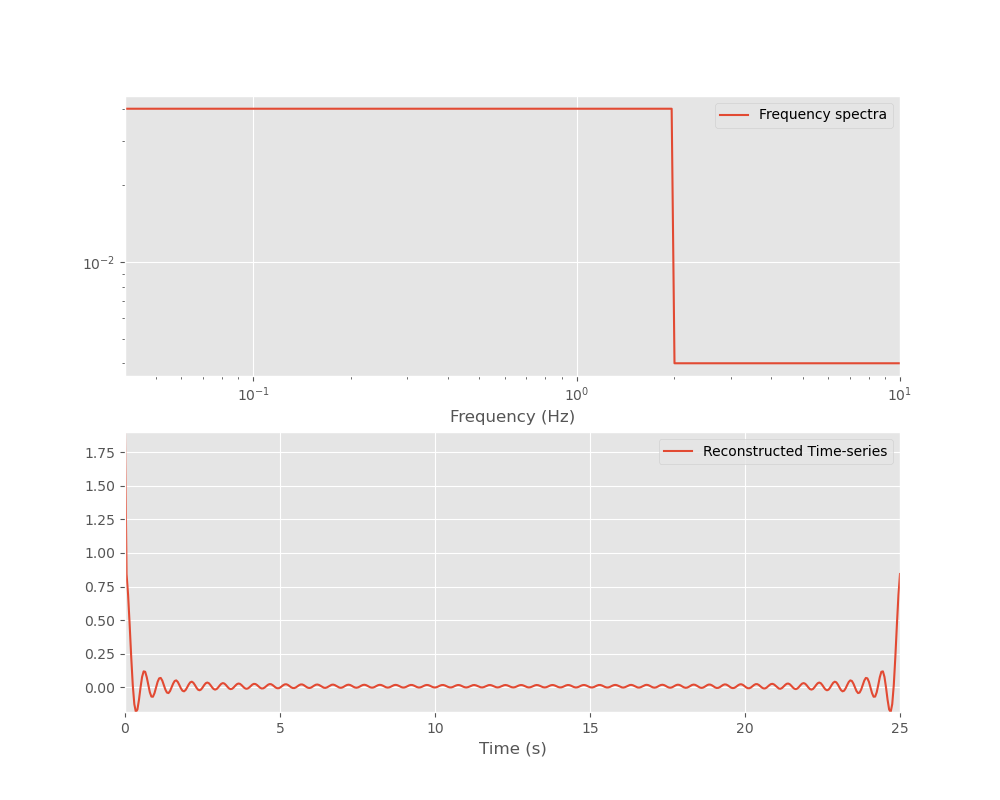

In [8]:
from scipy import fftpack
N = 500
dt = 0.05
step_position = 2  # Step position in Hz
sample_frequency = 1.0 / dt
nyquist = sample_frequency / 2.0

# Check that the step is within the resolved part of the amplitude spectra
if step_position >= nyquist:
    raise NotImplementedError(
        "Step should be below nyquist: {0}".format(nyquist))

# Make a flat frequency spectra first, of amplitude 10
frequency_amplitudes = np.ones(N) * 10
# Work out the frequency sample interval
frequency_interval = nyquist / int(N / 2)

# Insert a step into the amplitude spectra
step_location = int(step_position / frequency_interval)
frequency_amplitudes[step_location:] = np.ones_like(
    frequency_amplitudes[step_location:])
# Make the frequency sample points for plotting
frequency_samples = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))

# Do the inverse FFT
yr = fftpack.ifft(frequency_amplitudes)
x = np.linspace(0.0, N * dt, N)

# Plot the stepped amplitude spectra
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
ax[0].loglog(frequency_samples, 2./N * np.abs(frequency_amplitudes[:N//2]), 
             label="Frequency spectra")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[0].legend()

# Plot the resulting time-series from the inverse FFT
ax[1].plot(x, np.real(yr), label="Reconstructed Time-series")
ax[1].set_xlabel("Time (s)")
ax[1].autoscale(enable=True, axis='both', tight=True)
_ = ax[1].legend()

fig.show()

You will note that there are lots of oscillations at the start and end of the time-series.

**Exercise:** Try playing with the length of the Fourier transform (N) and see what it does 
to the ringing - what happens as you increase N and why do you think this happens? What do
you think that means for the accuracy of Fourier transforms of short seismic data?  

Hint, you need long time-series to accuretely represent long-period waves like the Earth's
normal modes.

# 2.0: Teleseismic vs. local signals

You know from class that:
1. Body waves attenuate at a rate of $a ~ r^{-2}$ where $a$ is amplitude and $r$ is distance;
2. Surface waves attenuate at a rate of $a ~ r^{-1}$;
3. Earthquakes start with a broad frequency range (more on source frequency content later: the relative amplitudes of different frequencies are different for different magnitudes; and are diagnostic of moment magnitude!)

That means that when we record close to an earthquake source we are likely to see higher frequencies than if we record at teleseismic distances.

Lets have a look at that for a recent earthquake in NZ.

We will start by getting some data from GeoNet for a relatively nearby station (be careful not to get a station that has clipped!), then we will get some data from IRIS for a teleseismic station for the same earthquake. I'm going to grab a station from the [global seismic network](https://www.fdsn.org/networks/detail/II/). You can use the IRIS [gmap](http://ds.iris.edu/gmap/#network=II&planet=earth) web-app to find stations.

In [9]:
# Get data
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

eventid = "2016p661332"
geonet_station = {
    "network": "NZ",
    "station": "MXZ", 
    "location": "10", 
    "channel": "HH?"}
iris_station = {
    "network": "II", 
    "station": "KDAK", 
    "location": "10", 
    "channel": "BH?"}
data_length = 3600

geonet_client = Client("GEONET")
iris_client = Client("IRIS")

event = geonet_client.get_events(eventid=eventid)[0]
origin = event.preferred_origin()

local_st = geonet_client.get_waveforms(
    starttime=origin.time, endtime=origin.time + data_length,
    **geonet_station)
print(local_st)

tele_st = iris_client.get_waveforms(
    starttime=origin.time, endtime=origin.time + data_length,
    **iris_station)
print(tele_st)

3 Trace(s) in Stream:
NZ.MXZ.10.HHE | 2016-09-01T16:37:55.438393Z - 2016-09-01T17:37:55.438393Z | 100.0 Hz, 360001 samples
NZ.MXZ.10.HHN | 2016-09-01T16:37:55.438393Z - 2016-09-01T17:37:55.438393Z | 100.0 Hz, 360001 samples
NZ.MXZ.10.HHZ | 2016-09-01T16:37:55.438393Z - 2016-09-01T17:37:55.438393Z | 100.0 Hz, 360001 samples
3 Trace(s) in Stream:
II.KDAK.10.BH1 | 2016-09-01T16:37:55.444539Z - 2016-09-01T17:37:55.419539Z | 40.0 Hz, 144000 samples
II.KDAK.10.BH2 | 2016-09-01T16:37:55.444539Z - 2016-09-01T17:37:55.419539Z | 40.0 Hz, 144000 samples
II.KDAK.10.BHZ | 2016-09-01T16:37:55.444539Z - 2016-09-01T17:37:55.419539Z | 40.0 Hz, 144000 samples


Now we can plot the two waveforms in the frequency and time domain using our function from before.

<IPython.core.display.Javascript object>


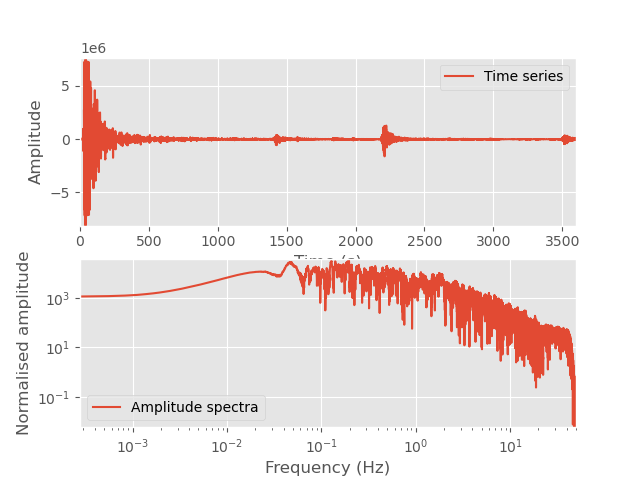

In [10]:
# Plot local
tr = local_st.select(channel="HHZ")[0]
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data
fig = plot_fft(x, y, reconstruct=False)
fig.show()

<IPython.core.display.Javascript object>


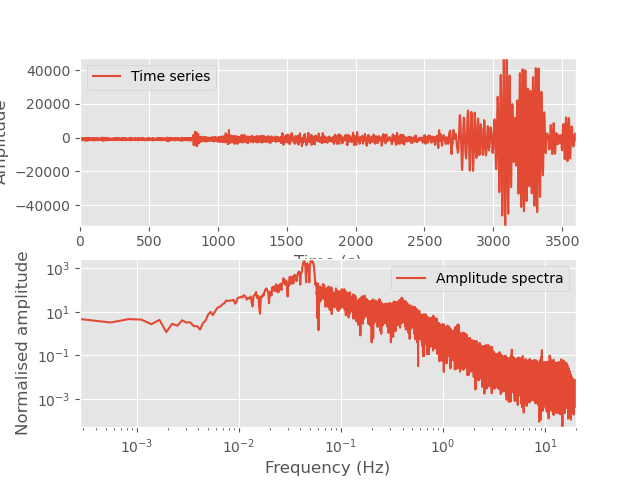

In [11]:
# Plot teleseismic
tr = tele_st.select(channel="BHZ")[0]
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data
fig = plot_fft(x, y, reconstruct=False)
fig.show()

**Question:** What are the dominant frequencies here? 
How do the body waves and surface waves differ? *Hint:* use some code like:
```python
tr = tele_st.select(channel="BHZ").slice(
    starttime=origin.time + 2500, endtime=origin.time + 3500)[0]
```
to "slice" a chunk of the waveform you are interested in.

Try plotting spectrograms as well to look at how frequency varies with time.

In [12]:
# Your plots here.

**Exercise:** Try doing this with another event of your choosing - try and pick something around the M 6 range, much bigger and local stations start to clip, much smaller and the signals become less clear teleseismically.

Just change the code above to whatever event and stations you want!

---
# 3.0: Filtering

Filtering seismic data alows us to increase the signal-to-noise ratio of specific frequency ranges that we are interested in.  
Remember that (from Stein and Wysession Figure 2.4-7) the range of frequencies for different types of seismic waves cover a wide
spectrum, with:
- reflection seismology often interested in signals in the 10Hz-1kHz range,
- earthquake seismology usually concerned with data in the 0.01-50Hz range and
- studies of normal modes thinking about frequencies in the 0.00001-0.01Hz range.

Surface waves also have different frequency content to body waves.  Because of this, we can filter the same data in different *pass-bands* to look at different features of the seismogram. A nice example of this is the seismogram of the Kaikoura 2016 M7.8 earthquake, recorded on White Island. While the Kaikoura earthquake was happening, the aftershock sequence of the Te Araroa M7.2 earthquake was going on (see [Warren-Smith et al., 2018](https://www.sciencedirect.com/science/article/pii/S0012821X17306568)
for more details). By filtering in different pass-bands we can see the surface waves from Kaikoura as well as the more local seismicity, which has a higher frequency content.

Lets download some data from GeoNet for the [WIZ station](https://www.geonet.org.nz/data/network/sensor/WIZ), which is a 
broadband sensor on the White Island volcano.
We will get data from the Kaikoura origin-time to quarter of an hour later.

<IPython.core.display.Javascript object>


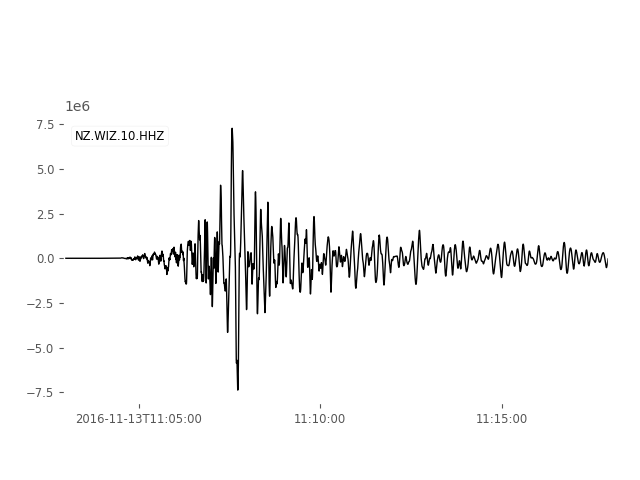

In [13]:
client = Client("GEONET")
kaikoura_origin_time = UTCDateTime(2016, 11, 13, 11, 2, 56)
st = client.get_waveforms(
    network="NZ", station="WIZ", channel="HHZ", location="10", 
    starttime=kaikoura_origin_time, endtime=kaikoura_origin_time + (15 * 60))
fig = st.plot(fig=plt.figure())

We can see the initial high-frequency body waves followed by strong low-frequency energy of the surface waves. 
You will also note that it takes a reasonable time for the first arriving seismic energy to reach this far from the earthquake.

We can visualise the frequencies nicely by looking at a spectrogram.  The spectrogram computes the frequency content
in moving windows along the trace and plots the normalised power of those frequencies as different colours. In the spectrogram
below you can clearly see the dominant low-frequency energy.

<IPython.core.display.Javascript object>


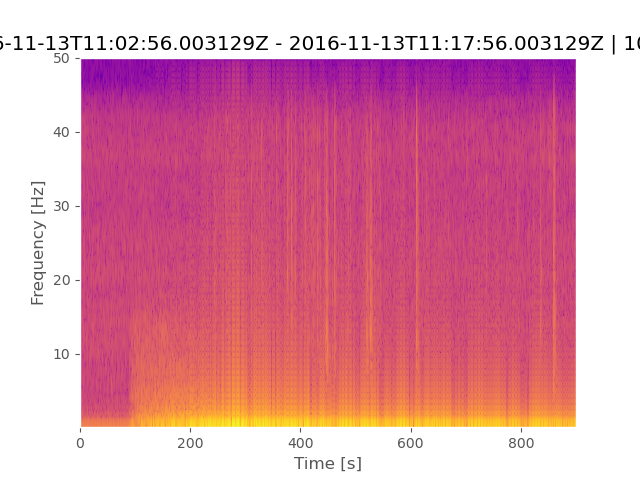

In [14]:
fig = st[0].spectrogram(dbscale=True, cmap="plasma")

Lets try and looks at just the high-frequencies.  Obspy has a convenient [`filter`](https://docs.obspy.org/master/packages/autogen/obspy.core.trace.Trace.filter.html#obspy.core.trace.Trace.filter) method on Stream and Trace objects.  We will use that before digging in to how
filtering works.

<IPython.core.display.Javascript object>


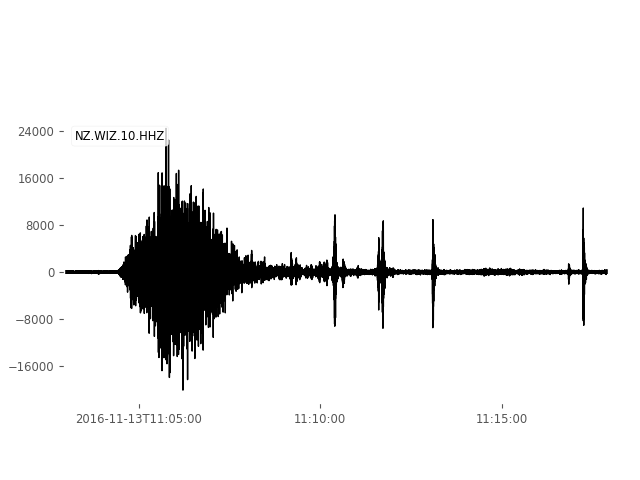

<IPython.core.display.Javascript object>


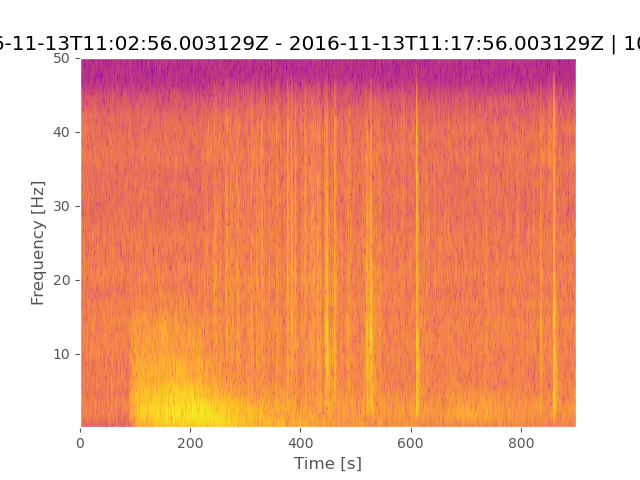

In [15]:
st_highpass = st.copy().filter("highpass", freq=2.)
st_highpass.plot(fig=plt.figure())
plt.show()
st_highpass.spectrogram(dbscale=True, cmap="plasma")
plt.show()

We can see a lot of emergent energy in the 1-15 Hz range associated with body waves from the Kaikoura earthquake itself in the beginning of this wave-train. However, the later bursts of energy are likely a more local source. We couldn't see those in the original, broadband waveform. Lets have a look at one of those more local events.

<IPython.core.display.Javascript object>


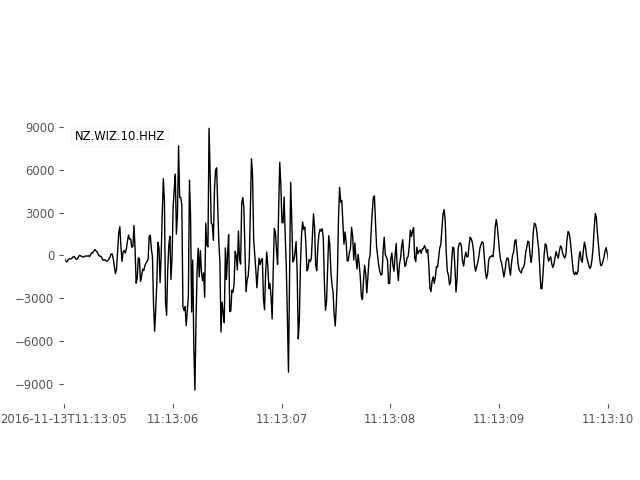

In [16]:
fig = st_highpass.plot(
    starttime=UTCDateTime(2016, 11, 13, 11, 13, 5),
    endtime=UTCDateTime(2016, 11, 13, 11, 13, 10), fig=plt.figure())

This is likely to be an aftershock of the Te Araroa sequence - there is dominant high-frequency energy. 
Unfortunately, stations closer to the Te Araroa epicenter have clipped waveforms - the signal from Kaikoura
exceeded the dynamic range of the sensor, which makes filter operations unstable.

Now lets try and just look at the low-frequency energy.

<IPython.core.display.Javascript object>


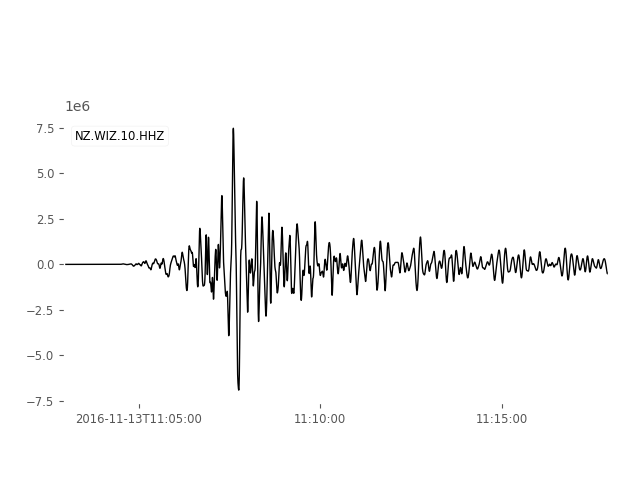

In [17]:
st_lowpass = st.copy().filter("lowpass", freq=.25)
fig = st_lowpass.plot(fig=plt.figure())

Now that we know that filters can be useful for various things, including separating energy from different sources, lets think about how filters work.

## How filters work

Filters work to remove energy at certain frequencies. This involves convolving some filter series with your data. In the time domain, convolution can be
a slow process, however, in the frequency domain, convolutions are simple multiplications. Because multiplication is a less computationally
expensive operation than convolution, filtering is often undertaken in the frequency domain.

In the next section we will think about some basic linear filters and look at different bandpass types, different filter window types, and
play with the order of the filters and the frequency ranges used.

First we will import a few functions from the `gphs445_utilities.tools` package that:
1. Design a filter in the frequency domain using scipy's 
   [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html#scipy.signal.iirfilter) function.
2. Apply the filter and plot the results in the time and frequency domains.

It is a good idea to have a quick look at the code for these functions (open the gphs445_utilities/tools.py file to see the code) and try and understand the basic idea in the `filter_and_plot` function.

It is worth noting that these filters only work for fairly simple filters, and in more general cases the use of
[second-order sections](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.sosfilt.html#scipy.signal.sosfilt)
is recommended.  Obspy uses *second-order sections* internally when you use the *filter* method.

In [18]:
from gphs445_utilities.tools import design_filter, filter_and_plot

### Lowpass filtering

We will first set up a simple low-pass filter.  Low-pass filters **remove** high frequencies, and allow low frequencies
to *pass-through*.

**Exercise:** Play with different window types, low passes and filter orders.

<IPython.core.display.Javascript object>


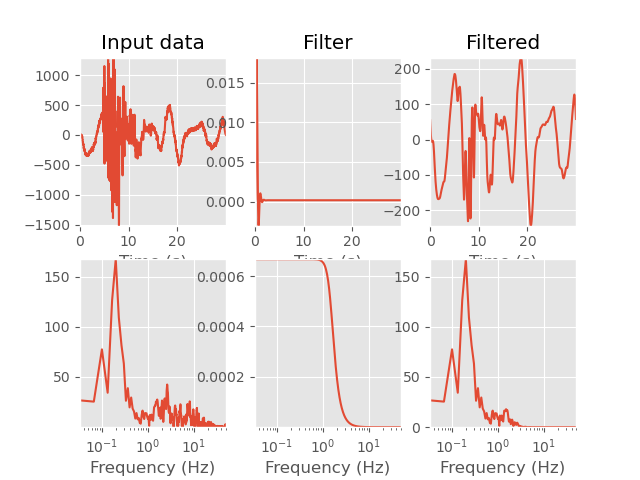

In [19]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[0.75], order=4, window_type="butter",
    filter_type="lowpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### Highpass filtering

High-pass filters **remove** low frequencies, and allow high frequencies to *pass-through*.

**Exercise:** Play with different window types, high passes and filter orders.

<IPython.core.display.Javascript object>


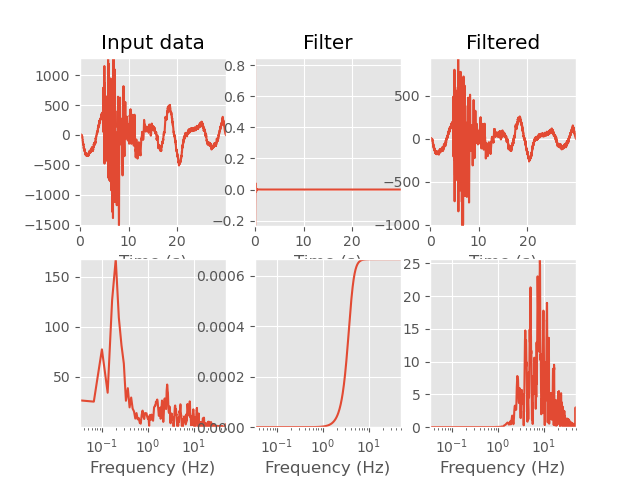

In [20]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[2.], order=4, window_type="butter",
    filter_type="highpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### Bandpass filtering

Bandpass filters allow a range of frequencies to pass through.  We commonly refer to the frequencies that are retained as
the *pass-band*.

**Exercise:** Play with different window types and low and high cuts. You can add more than two corners to make a more complex filter.

<IPython.core.display.Javascript object>


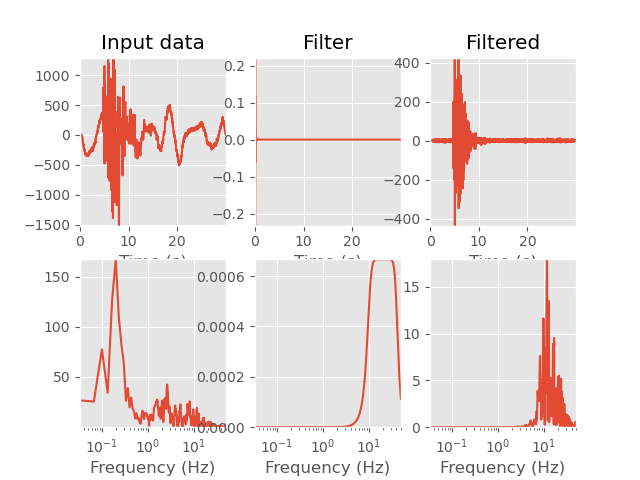

In [21]:
tr = read()[0]
tr = tr.detrend()  # Data must be de-trended before filtering

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[5., 20.], order=4, window_type="butterworth",
    filter_type="bandpass", attenuation=10)
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

## Causality

*The theory of filters is not covered extensively in these notebooks and students are referred to the **Time-Series Analysis and Inverse Theory** textbook by Gubbins for more details*

So far we have just looked at single-pass filters.  These output a causal waveform: there is no signal before the real signal arrived, however peaks in the waveform might be shifted. We can change this by thinking about the *phase* of our filter. 

When we compute Fourier transforms we obtain a real part and a complex part. The real part is the amplitude spectrum that we have looked at so far, but the complex part describes the phase spectrum. We have not been picky about the phase of our filters thus far, and there are an infinite number of possible causal filters for a single amplitude spectrum. Usually the minimum phase filter is used, which concentrates energy at the front of the time series. The above filters were mixed phase - energy was distributed throughout the time-series.

To avoid shifting peaks in the waveform we can use a **zero-phase** filter.  This zero-phase filter is *acausal*: it is symmertical about the origin time and shifts some energy to occur *before* the original signal. Note that this can result in apparently earlier arrivals, you must be careful when applying filters prior to estimating seismic phase arrivals! Zerophase filters can be acheived by running the same filter forwards then backwards.  This has the effect of increasing the order of the final filter (e.g. a 2nd order filter becomes a 4th order filter). 

Below we demonstrate this using obspy filter method:

<IPython.core.display.Javascript object>


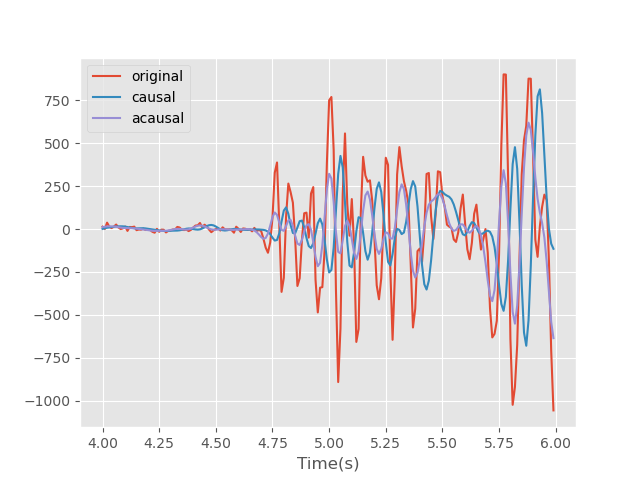

In [22]:
tr_highpass = tr.copy().filter("highpass", freq=1)  
# Remove background noise to simplify comparison
tr_acausal = tr_highpass.copy().filter(
    "lowpass", freq=10, corners=2, zerophase=True)
tr_causal = tr_highpass.copy().filter(
    "lowpass", freq=10, corners=4, zerophase=False)
plot_start, plot_end = (4.0, 6.0)

fig, ax = plt.subplots()
x_time = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
plot_start_ind = int(plot_start * tr.stats.sampling_rate)
plot_end_ind = int(plot_end * tr.stats.sampling_rate)
trace_dict = {
    "original": tr_highpass,
    "causal": tr_causal,
    "acausal": tr_acausal}
for label, _tr in trace_dict.items():
    ax.plot(x_time[plot_start_ind: plot_end_ind], 
            _tr.data[plot_start_ind: plot_end_ind],
            label=label)
ax.legend()
_ = ax.set_xlabel("Time(s)")  # do not check returned value

If you focus on the first arrival you will note that the causal waveform only has energy after the original
waveform has energy, but the peaks are shifted.  In contrast, the acausal waveform has energy before
the original, but the peaks generally align with the original.

**Exercise:** Try changing the order of the above filters and see what happens.  The order of the filter affects the slope of the filter.  If the slope is too steep you may see ringing effects due to
Gibb's phenomenon.

## Poles and Zeros

Filters are often represented as *poles and zeros*. These are the roots of the denominator and
numerator of the transfer function resepectively. For example, if we have a filter defined by:
\begin{equation*}
    H(s) = \frac{s + 2}{s^2 + 0.25}
\end{equation*}
the zeros of this filter would be a single zero at $s=-2$, and the poles would be at 
$s=i\sqrt{0.25}, -i\sqrt{0.25}$.

Transfer functions for butterworth filters, one of the more commonly used filters in seismology
because it has no ripple (unlike the Chebychev filters, however Butterworth filters have the disadvantage that they can introduce time and phase shifts)
take the form:
\begin{equation*}
    G^2(\omega) = |H(i\omega)|^2 = \frac{G_0^2}{1 + \frac{i\omega}{i\omega_c}^{2n}}
\end{equation*}
where $\omega$ is the angular frequency, $\omega_c$ is the cut-off frequency (the frequency that should result in a reduction in amplitude gain of 50%), $G$ is
gain, $G_0$ is the gain at DC ($\omega=0$ and $n$ is the order of the filter.  Note that the number
of poles is equal to $2n$.

Below is a demontration of increasing the order of a butterworth lowpass filter.  Note that the
slope increases with the order approaching a discontinuity.  The ideal filter would remove all
unwanted frequencies and retain all wanted frequencies without attenuation.  This would look
like a step in the frequency domain, however, such a discontinuity is unstable and results
in *ringing* also know as Gibb's phenomenon.

<IPython.core.display.Javascript object>


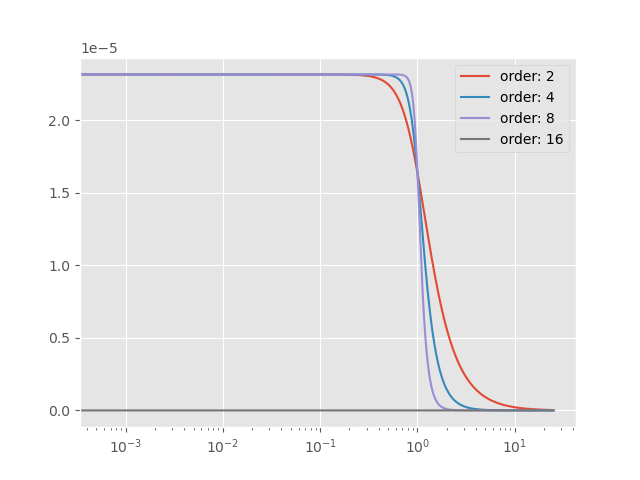

In [23]:
fig, ax = plt.subplots()
N = 86400
sample_rate = 50
dt = 1 / sample_rate
for order in [2, 4, 8, 16]:
    filt = design_filter(
        sample_rate=sample_rate, data_length=N,
        corners=[0.5], order=order, window_type="butter",
        filter_type="lowpass")
    x_freq = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    ax.semilogx(x_freq, 2./N * np.abs(filt[:N//2]),
                label="order: {0}".format(order))
_ = ax.legend()  # Do not check returned value

## Resampling

Earlier we made use of naive decimation of data (taking every $n^{th}$ sample), however, there are
better/different ways to change the sampling rate of data.  We will explore two methods, the first
is frequency domain resampling, employed by obspy in the `.resample` method.  This effectively
re-maps the frequency spectra of your data onto a differently sampled frequency range.  One advantage of this method is that you can resample to any frequency, instead of just integer division of the original sampling-rate. Frequency-domain resampling can also
be used for either downsampling or upsampling data.  However, because it uses the FFT it is
susceptible to all the usual things associated with FFTs, most notable, Gibb's phenomenon.
The cell below contains a function to do this frequency domain resampling, the basic outline
of this function is:
1. Compute the (real) FFT of the data
2. Convolve the spectra with a [hanning window](https://numpy.org/devdocs/reference/generated/numpy.hanning.html) (other windows are available)
    - This has the effect of stabalising discontinuities at the edge of the spectra
3. Re-map the spectra onto a new frequency range
    - Here we use the numpy `interp` function (if we were just decimating by an
      integer factor, we could just remove the spectra above the new Nyquist)
4. Compute the inverse (real) FFT to get the newly resampled data.

The code for this is a little complicated, but you should have a quick look at it. It is in the
`gphs445_utilities/tools.py` file.

<IPython.core.display.Javascript object>


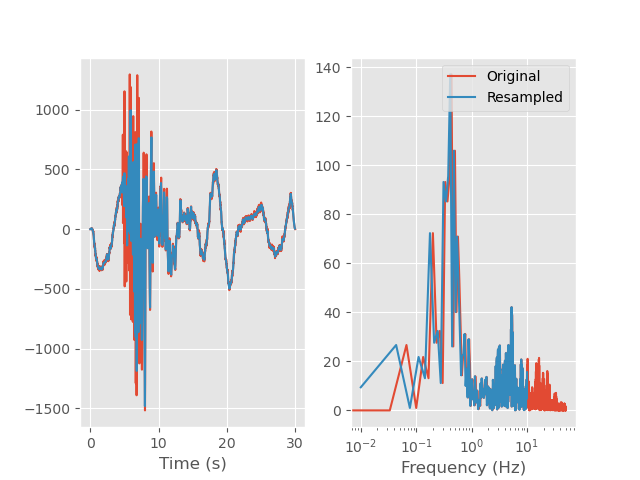

In [24]:
from gphs445_utilities.tools import resample_and_plot

tr_resampled, fig = resample_and_plot(tr, 20)

fig.show()

The plots generated show the original data overlain with the resampled data.  You will note that the low frequencies are mostly maintained in the time-series, but we lose high-frequency energy.  In the spectra plots the resampled spectra looks very similar to the original spectra up to the newly
selected Nyquist, where the resampled spectra stops.  There is a slight shift between the spectra,
which shows up as misallignment at low frequencies (note this shift is throughout the spectra, but
the log scale makes it more obvious at low frequencies).  This shift is not real and arrises
due to the original spectra being padded with an adidtional zero at the start.

**Exercise:** Try different sampling frequencies. 
What do the data look like when you over-sample them?
What about when you drop down to 1.5 Hz?

### Upsampling - sinc resampling

Often in earthquake seismology we want to reduce the sampling rate after recording (remembering that
even if we later increase the sampling rate we will not be able to capture additional energy above
the Nyquist frequency).  However, sometimes we need data at high sampling rates.  Resampling in
the frequency domain allows us to do this, but often does not accurately capture the peak amplitudes
of the data.  

One of the better methods of doing this kind of upsampling is to use sinc interpolation.  The sinc
function:
\begin{equation*}
    \operatorname{sinc}(x) = \frac{\sin(x)}{x}
\end{equation*}
is the theoretical optimum reconstruction filter for band-limited signals - it is the closest
periodic function to a delta (spike):

/tmp/ipykernel_1393551/3579324277.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


<IPython.core.display.Javascript object>


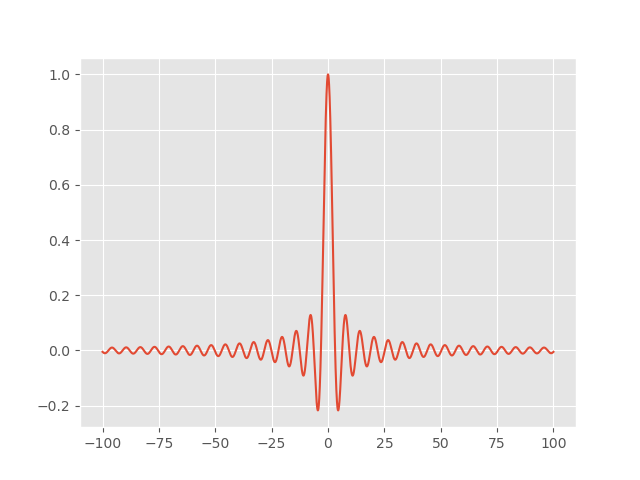

In [25]:
x = np.arange(-100, 100, 0.01)
y = np.sin(x) / x
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

If we add multiple sinc functions together we can start to construct box-car functions (functions that are zero-valued everywhere except in a range where the function is equal to some 
non-zero value).  This happens because we can align the functions such that deconstuctive 
interferance happens everywhere apart from at the peak of the function:

<IPython.core.display.Javascript object>


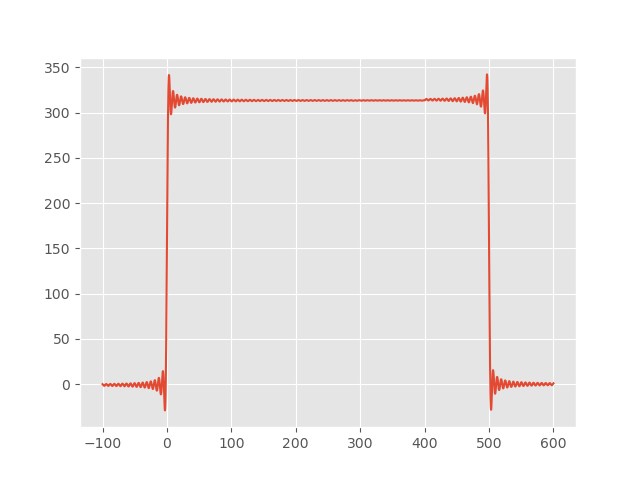

In [26]:
x = np.arange(-100, 600, 0.01)
y = np.zeros_like(x)
sinc = np.sin(x) / x
y += sinc
for shift_no in range(1, 50000):
    y[shift_no:] += sinc[0:-shift_no]
fig, ax = plt.subplots()
ax.plot(x, y)
plt.show()

We can make use of the sinc function to interpolate seismic data.  For finite data we cannot use a
true sinc function, but we can use Lanczos resampling which is a finite version of sinc interpolation, and is supported by obspy.  Below is a
demonstration of how frequency domain resampling reduces the amplitude of peaks in data, but
Lanczos does a good job of matching the original data.

<IPython.core.display.Javascript object>


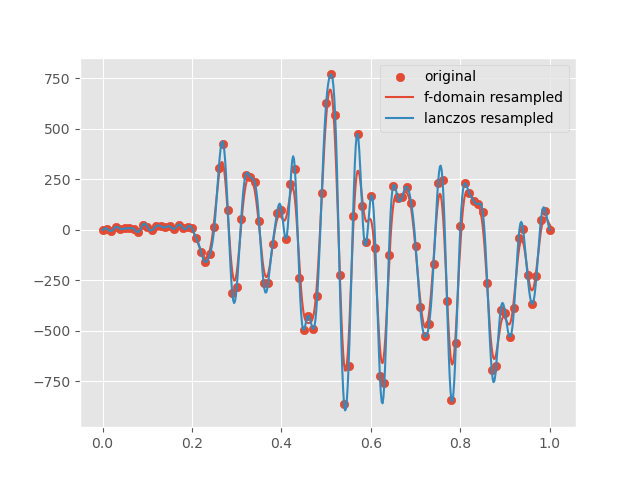

In [27]:
new_rate = 500

tr_trimmed = tr.copy().trim(
    tr.stats.starttime + 4.5, tr.stats.starttime + 5.5).detrend()
tr_resampled = tr_trimmed.copy().resample(new_rate)
tr_lanczos = tr_trimmed.copy().interpolate(
    new_rate, method="lanczos", a=20)

fig, ax = plt.subplots(1)
ax.scatter(
    np.arange(0, tr_trimmed.stats.npts * tr_trimmed.stats.delta,
              tr_trimmed.stats.delta),
    tr_trimmed.data, label="original")
ax.plot(
    np.arange(0, tr_resampled.stats.npts * tr_resampled.stats.delta,
              tr_resampled.stats.delta),
    tr_resampled.data, label="f-domain resampled")
ax.plot(
    np.arange(0, tr_lanczos.stats.npts * tr_lanczos.stats.delta,
              tr_lanczos.stats.delta),
    tr_lanczos.data, label="lanczos resampled")
ax.legend()
plt.show()

## Conclusion

That concludes our look into Fourier transforms, filtering and resampling.  The ideas behind frequency domain operations
are often hidden in seismic software, so it is important to understand what you are doing to your
data: the filtering that you perform can increase signal-to-noise ratio, but you have to be careful
that you are not destroying or altering something that you care about (e.g. time or amplitude).